## HW1
### 주어진 ./data/minidata안의 파일 안에서 64x64 사이즈의 고양이와 128X128 사이즈의 강아지, 그리고 각각의 파일 명을 내 뱉는 Dataloader를 만드시오
### Data augmentation은 train일 경우 Horizon Flip, 랜덤90도 rotation, 랜덤 Crop을, train이 아닌 경우 하지 않도록 작성하시오

In [ ]:
from torchvision import datasets
from torch.utils.data import Dataset
from torchvision import datasets, transforms

from PIL import Image
import os
from glob import glob

In [ ]:
# colab에서 상대경로를 이용하기 위한 코드. 과제 시연땐 무시해주세요
from google.colab import drive


drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive/Colab Notebooks/수업/20211224') 

Mounted at /content/drive


In [ ]:
class HwDataset(Dataset):
    def __init__(self, train_dir = './data/minidata/train', train = False):
        self.train_dir = train_dir
        self.train = train
        self.dog_data = glob(os.path.join(self.train_dir, 'dog', '*'))
        self.cat_data = glob(os.path.join(self.train_dir, 'cat', '*'))
        self.train_transform = transforms.Compose([transforms.RandomResizedCrop(128),
                                             transforms.RandomRotation((-90, 90)),
                                             transforms.RandomHorizontalFlip(),
                                             ])
        self.cat_transform = transforms.Compose([transforms.Resize((64, 64)),
                                                 transforms.ToTensor(),
                                                  ])
        self.dog_transform = transforms.Compose([transforms.Resize((128, 128)),
                                                 transforms.ToTensor(),
                                                  ])
        

    def __len__(self):
        return len(self.dog_data) + len(self.cat_data)
    

    def __getitem__(self, index):
        dog = Image.open(self.dog_data[index]).convert('RGB')
        cat = Image.open(self.cat_data[index]).convert('RGB')
        dogname = self.dog_data[index].split('/')[-1]
        catname = self.cat_data[index].split('/')[-1]
        if self.train:
            dog = self.train_transform(dog)
            cat = self.train_transform(cat)
        dog = self.dog_transform(dog)
        cat = self.cat_transform(cat)
        
        return cat, dog, catname, dogname


In [ ]:
train_dataset = HwDataset('./data/minidata/train',train=True)
val_dataset = HwDataset('./data/minidata/val',train=False)

## HW2
### 2_NeuralNetwork.ipynb의 Let's Do It 코드를 작성해서 결과를 확인하시오

In [ ]:
# 필요한 train test코드를 다 작성하세요

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.datasets as vision_dsets
import torchvision.transforms as T
import torch.optim as optim
from torch.utils import data

from torchvision import datasets
from torch.utils.data import Dataset
from torchvision import datasets, transforms


os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [ ]:
def MNIST_DATA(root='./data',train =True,transforms=None ,download =True,batch_size = 32,num_worker = 1):
    print ("[+] Get the MNIST DATA")
    mnist_train = vision_dsets.MNIST(root = root,
                                    train = True,
                                    transform = T.ToTensor(),
                                    download = True)
    mnist_test = vision_dsets.MNIST(root = root,
                                    train = False,
                                    transform = T.ToTensor(),
                                    download = True)
 
    trainDataLoader = data.DataLoader(dataset = mnist_train,
                                      batch_size = batch_size,
                                      shuffle =True,
                                      num_workers = 1)

    testDataLoader = data.DataLoader(dataset = mnist_test,
                                    batch_size = batch_size,
                                    shuffle = False,
                                    num_workers = 1)
    print ("[+] Finished loading data & Preprocessing")
    
    return mnist_train,mnist_test,trainDataLoader,testDataLoader

In [ ]:
trainDset, testDset, trainDataLoader, testDataLoader= MNIST_DATA(batch_size = 32)

[+] Get the MNIST DATA
[+] Finished loading data & Preprocessing


In [ ]:
class Trainer():
    def __init__(self, trainloader, testloader, net, optimizer, criterion):
        self.trainloader = trainloader
        self.testloader = testloader
        self.net = net
        self.optimizer = optimizer
        self.criterion = criterion
        
    def train(self, epoch = 1):
        self.net.train()
        for e in range(epoch):
            running_loss = 0.0
            for i, data in enumerate(self.trainloader, 0):
                # get the inputs
                inputs, labels = data
                inputs = inputs.cuda()
                labels = labels.cuda()
                self.optimizer.zero_grad()

                outputs = self.net(inputs)
                loss = self.criterion(outputs, labels)
                loss.backward()
                self.optimizer.step()

                running_loss += loss.item()
                if (i+1) % 500 == 0:
                    print('[%d, %5d] loss: %.3f' % (e + 1, i + 1, running_loss / 500))
                    running_loss = 0.0

        print('Finished Training')
        
    def test(self):
        self.net.eval()
        test_loss = 0
        correct = 0
        for inputs, labels in self.testloader:
            inputs = inputs.cuda()
            labels = labels.cuda() 
            output = self.net(inputs) 
            pred = output.max(1, keepdim=True)[1]
            correct += pred.eq(labels.view_as(pred)).sum().item()

            test_loss /= len(self.testloader.dataset)
        print('\nTest set:  Accuracy: {}/{} ({:.0f}%)\n'.
                format(correct, len(self.testloader.dataset),
                100.* correct / len(self.testloader.dataset)))

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [ ]:
class MNIST_Net(nn.Module):
    def __init__(self):
        super(MNIST_Net, self).__init__()
        self.cnn1 = nn.Conv2d(in_channels=1, out_channels=8, kernel_size=5, stride=1, padding=0)
        self.relu1 = nn.ReLU()
        
        # Max pool 1
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)
     
        # Convolution 2
        self.cnn2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=5, stride=1, padding=0)
        self.relu2 = nn.ReLU()
        
        # Max pool 2
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)
        
        # Fully connected 1
        self.fc1 = nn.Linear(16 * 4 * 4, 10) 
    
    def forward(self, x):
        # Convolution 1
        x = self.cnn1(x)
        x = self.relu1(x)
        
        # Max pool 1
        x = self.maxpool1(x)
        
        # Convolution 2 
        x = self.cnn2(x)
        x = self.relu2(x)
        
        # Max pool 2 
        x = self.maxpool2(x)
        
        # flatten
        x = x.view(x.shape[0], -1)

        # Linear function
        x = self.fc1(x)
        
        return x

In [ ]:
mnist_net = MNIST_Net().cuda()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(mnist_net.parameters(), lr=0.001)

In [ ]:
count_parameters(mnist_net)

5994

In [ ]:
trainer = Trainer(trainloader = trainDataLoader,
                  testloader = testDataLoader,
                  net = mnist_net,
                  criterion = criterion,
                  optimizer = optimizer)

In [ ]:
trainer.train(epoch = 4)

[1,   500] loss: 0.530
[1,  1000] loss: 0.195
[1,  1500] loss: 0.134
[2,   500] loss: 0.103
[2,  1000] loss: 0.091
[2,  1500] loss: 0.085
[3,   500] loss: 0.071
[3,  1000] loss: 0.064
[3,  1500] loss: 0.063
[4,   500] loss: 0.054
[4,  1000] loss: 0.054
[4,  1500] loss: 0.049
Finished Training


In [ ]:
trainer.test()


Test set:  Accuracy: 9869/10000 (99%)



## (Optional) HW3
### 3_VGG.ipynb를 참조해 VGG16을 구현하세요

In [ ]:
class ConvBlock1(nn.Module):

    def __init__(self, in_dim, out_dim):
        super(ConvBlock1, self).__init__()
        
        self.in_dim = in_dim
        self.out_dim = out_dim
        
        self.main = nn.Sequential(nn.Conv2d(self.in_dim, self.out_dim, kernel_size=3, padding=1),                    
                                  nn.BatchNorm2d(self.out_dim, eps=1e-05, momentum=0.1, affine=True),
                                  nn.ReLU(),
                                  nn.Conv2d(self.out_dim, self.out_dim, kernel_size=3, padding=1),                    
                                  nn.BatchNorm2d(self.out_dim, eps=1e-05, momentum=0.1, affine=True),
                                  nn.ReLU(),
                                  nn.MaxPool2d(kernel_size=2, stride=2),
                                 )
        
    def forward(self, x):
        out = self.main(x)
        return out

In [ ]:
class ConvBlock2(nn.Module):

    def __init__(self, in_dim, out_dim):
        super(ConvBlock2, self).__init__()
        
        self.in_dim = in_dim
        self.out_dim = out_dim
        
        self.main = nn.Sequential(nn.Conv2d(self.in_dim, self.out_dim, kernel_size=3, padding=1),                    
                                  nn.BatchNorm2d(self.out_dim, eps=1e-05, momentum=0.1, affine=True),
                                  nn.ReLU(),
                                  nn.Conv2d(self.out_dim, self.out_dim, kernel_size=3, padding=1),                    
                                  nn.BatchNorm2d(self.out_dim, eps=1e-05, momentum=0.1, affine=True),
                                  nn.ReLU(),
                                  nn.Conv2d(self.out_dim, self.out_dim, kernel_size=3, padding=1),                    
                                  nn.BatchNorm2d(self.out_dim, eps=1e-05, momentum=0.1, affine=True),
                                  nn.ReLU(),
                                  nn.MaxPool2d(kernel_size=2, stride=2),
                                 )
        
    def forward(self, x):
        out = self.main(x)
        return out

In [ ]:
class VGG16(nn.Module):
  
    def __init__(self):
        super(VGG16, self).__init__()
        
        self.convlayer1 = ConvBlock1(3, 64)
        self.convlayer2 = ConvBlock1(64, 128)
        self.convlayer3 = ConvBlock2(128, 256)
        self.convlayer4 = ConvBlock2(256, 512)
        self.convlayer5 = ConvBlock2(512, 512)
        self.linear = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, 10),
        )
    def forward(self, input):
        out = self.convlayer1(input)    
        out = self.convlayer2(out)
        out = self.convlayer3(out)
        out = self.convlayer4(out)
        out = self.convlayer5(out).squeeze() # 16 x 512 x 1 x 1에서 뒤 1 x 1 축약
        out = out.view(out.shape[0], -1)
        out = self.linear(out)
        return out


In [ ]:
vgg16 = VGG16()
print(vgg16)

VGG16(
  (convlayer1): ConvBlock1(
    (main): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
      (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
  )
  (convlayer2): ConvBlock1(
    (main): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
      (6): MaxPool2d(kernel_size=2, stride=2,

# CIFAR-10 Dataset

In [ ]:
# set hyperparameters
batch_size = 64
learning_rate = 0.0001
num_epochs = 4

In [ ]:
# import torchvision.datasets as datasets

train_dataset = datasets.CIFAR10(root='./data/cifar/',       # 50000장
                            train=True, 
                            transform=transforms.ToTensor(),
                            download=True)

test_dataset = datasets.CIFAR10(root='./data/cifar/',        # 10000장
                           train=False, 
                           transform=transforms.ToTensor())

# 데이터 로더
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size, 
                                          shuffle=True)

Files already downloaded and verified


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import time
import datetime
from torch.autograd import Variable


def show_cifar10():
    for images, _ in train_loader:
        plt.figure(figsize=(8,8))
        images_to_show = images.numpy().transpose((0,2,3,1))

        for a in range(331, 340):  
            plt.subplot(a)
            plt.imshow(images_to_show[a-331])
            plt.xticks([])
            plt.yticks([])    
            plt.show()   
        break
    return 0


def loss_plot(acc):  
    plt.plot(acc)
    plt.xlabel('log')
    plt.ylabel('accuracy')
    plt.grid(True)
    plt.show()
    return 0


class Timer():    
    def __init__(self):
        self.cur_t = time.time()

    def tic(self):
        self.cur_t = time.time()

    def toc(self):
        return time.time() - self.cur_t

    def tocStr(self, t=-1):
        if (t == -1):
            return str(datetime.timedelta(seconds=np.round(time.time() - self.cur_t, 3)))[:-4]
        else:
            return str(datetime.timedelta(seconds=np.round(t, 3)))[:-4]
          

def test_on_cifar10(model, accuracy_list):  
    # Test the Model       
    model.eval()    # Change model to 'eval' mode (BN uses moving mean/var).
    correct = 0
    total = 0
    for j, (images, labels) in enumerate(test_loader):
        images = Variable(images).cuda()
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted.cpu() == labels).sum()
        if (j+1)%100==0:
            break

    print('Test Accuracy of the model on the 100 test images: %d %%' % (100 * correct.float() / total))
    accuracy_list.append(100 * correct.float() / total) 
    return accuracy_list

Epoch [1/4], Iter [100/781] Loss: 1.7202, iter_time: 10.42
Test Accuracy of the model on the 100 test images: 32 %
Epoch [1/4], Iter [200/781] Loss: 1.9861, iter_time: 13.81
Test Accuracy of the model on the 100 test images: 23 %
Epoch [1/4], Iter [300/781] Loss: 1.8951, iter_time: 13.79
Test Accuracy of the model on the 100 test images: 30 %
Epoch [1/4], Iter [400/781] Loss: 1.4835, iter_time: 13.79
Test Accuracy of the model on the 100 test images: 35 %
Epoch [1/4], Iter [500/781] Loss: 1.5304, iter_time: 13.78
Test Accuracy of the model on the 100 test images: 33 %
Epoch [1/4], Iter [600/781] Loss: 1.5655, iter_time: 13.75
Test Accuracy of the model on the 100 test images: 41 %
Epoch [1/4], Iter [700/781] Loss: 1.7714, iter_time: 13.72
Test Accuracy of the model on the 100 test images: 44 %


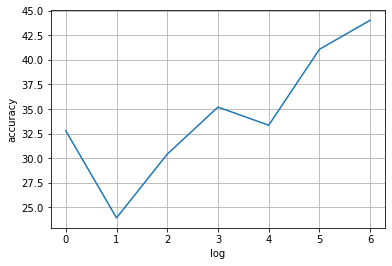

Epoch [2/4], Iter [100/781] Loss: 1.4763, iter_time: 22.28
Test Accuracy of the model on the 100 test images: 47 %
Epoch [2/4], Iter [200/781] Loss: 1.2833, iter_time: 13.77
Test Accuracy of the model on the 100 test images: 49 %
Epoch [2/4], Iter [300/781] Loss: 1.0583, iter_time: 13.78
Test Accuracy of the model on the 100 test images: 53 %
Epoch [2/4], Iter [400/781] Loss: 1.3873, iter_time: 13.82
Test Accuracy of the model on the 100 test images: 54 %
Epoch [2/4], Iter [500/781] Loss: 1.0705, iter_time: 13.83
Test Accuracy of the model on the 100 test images: 54 %
Epoch [2/4], Iter [600/781] Loss: 1.1892, iter_time: 13.80
Test Accuracy of the model on the 100 test images: 57 %
Epoch [2/4], Iter [700/781] Loss: 1.0345, iter_time: 13.80
Test Accuracy of the model on the 100 test images: 58 %


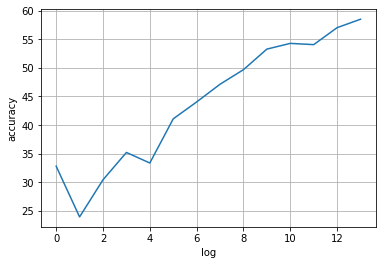

Epoch [3/4], Iter [100/781] Loss: 0.9314, iter_time: 22.29
Test Accuracy of the model on the 100 test images: 61 %
Epoch [3/4], Iter [200/781] Loss: 1.2471, iter_time: 13.80
Test Accuracy of the model on the 100 test images: 58 %
Epoch [3/4], Iter [300/781] Loss: 0.8749, iter_time: 13.81
Test Accuracy of the model on the 100 test images: 65 %
Epoch [3/4], Iter [400/781] Loss: 1.1770, iter_time: 13.79
Test Accuracy of the model on the 100 test images: 61 %
Epoch [3/4], Iter [500/781] Loss: 0.9371, iter_time: 13.82
Test Accuracy of the model on the 100 test images: 65 %
Epoch [3/4], Iter [600/781] Loss: 1.0491, iter_time: 13.84
Test Accuracy of the model on the 100 test images: 65 %
Epoch [3/4], Iter [700/781] Loss: 1.0391, iter_time: 13.88
Test Accuracy of the model on the 100 test images: 66 %


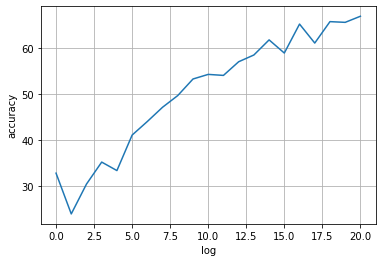

Epoch [4/4], Iter [100/781] Loss: 0.7455, iter_time: 22.27
Test Accuracy of the model on the 100 test images: 69 %
Epoch [4/4], Iter [200/781] Loss: 0.8286, iter_time: 13.81
Test Accuracy of the model on the 100 test images: 66 %
Epoch [4/4], Iter [300/781] Loss: 0.4526, iter_time: 13.80
Test Accuracy of the model on the 100 test images: 69 %
Epoch [4/4], Iter [400/781] Loss: 0.8849, iter_time: 13.80
Test Accuracy of the model on the 100 test images: 69 %
Epoch [4/4], Iter [500/781] Loss: 0.6477, iter_time: 13.80
Test Accuracy of the model on the 100 test images: 70 %
Epoch [4/4], Iter [600/781] Loss: 0.8593, iter_time: 13.83
Test Accuracy of the model on the 100 test images: 68 %
Epoch [4/4], Iter [700/781] Loss: 1.0260, iter_time: 13.80
Test Accuracy of the model on the 100 test images: 69 %


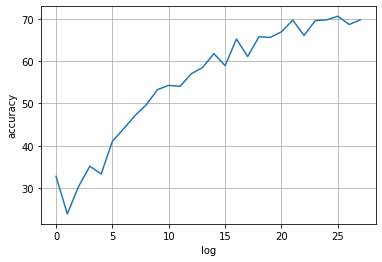

In [ ]:
import torchvision.models as models


vgg16 = VGG16()

tell_time = Timer()
iter_time = 0

vgg16 = vgg16.cuda()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(vgg16.parameters(), lr=learning_rate)

accuracy_list = []
for epoch in range(num_epochs):
    vgg16.train()
    for i, (images, labels) in enumerate(train_loader):
        images = Variable(images).cuda()
        labels = Variable(labels).cuda()

        # Forward + Backward + Optimize
        optimizer.zero_grad()
        outputs = vgg16(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        if (i+1) % 100 == 0:
            print ('Epoch [%d/%d], Iter [%d/%d] Loss: %.4f, iter_time: %2.2f' 
                 %(epoch+1, num_epochs, i+1, len(train_dataset)//batch_size, loss.item(), tell_time.toc()-iter_time))
            iter_time = tell_time.toc()    
            accuracy_list = test_on_cifar10(vgg16, accuracy_list)

    loss_plot(accuracy_list)